## Gaussian Processes (GP) with GPyTorch

In this notebook we are going to use [GPyTorch](https://gpytorch.ai/) library for GP modeling.

Why **GPyTorch**?

* State of the art GP models
* Built on top of pytorch having all its advantages (GPU, autograd, etc)


Run the following line to install GPyTorch library

In [1]:
!pip install gpytorch
!git clone https://github.com/yeahrmek/BayesOpt_tutorial

import os
os.chdir('BayesOpt_tutorial/GP')

     |████████████████████████████████| 310 kB 6.9 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509894 sha256=00ae5c01f84d885ebf92f5662bb772f3d4bc0aa2e8352d95ad9781b49045d61f
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch
Cloning into 'BayesOpt_tutorial'...
remote: Enumerating objects: 57, done.
remote: Total 57 (delta 0), reused 0 (delta 0), pack-reused 57
Unpacking objects: 100% (57/57), done.


In [2]:
%matplotlib inline


import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
from gpytorch import kernels


import utils
import tqdm

Current documentation of GPyTorch library can be found [here](https://gpytorch.readthedocs.io/en/latest/).

## Gaussian Process Regression

A data set $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$ is given.  

Assumption:
$$
y = f(x) + \varepsilon,
$$
where $f(x)$ is a Gaussian Processes and $\varepsilon \sim \mathcal{N}(0, \sigma_n^2)$ is a Gaussian noise .

Posterior distribution
$$
y_* | X, \mathbf{y}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)),
$$
with predictive mean and variance given by
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$
where
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$
$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_n^2 \mathbf{I}
$$

## Building GPR model

Lets fit GPR model for function $f(x) = − \cos(\pi x) + \sin(4\pi x)$ in $[0, 1]$,
with noise $y(x) = f(x) + \epsilon$, $\epsilon \sim \mathcal{N}(0, 0.1)$. 

In [3]:
torch.manual_seed(1150061746)

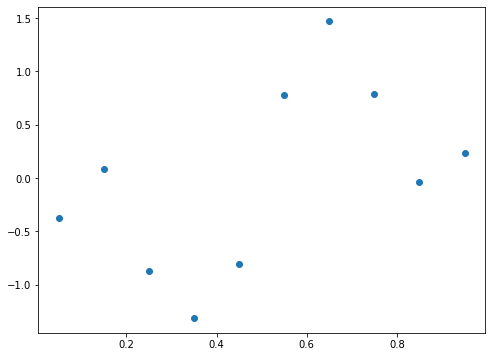

In [4]:
N = 10
X = torch.linspace(0.05, 0.95, N)
y = -torch.cos(np.pi * X) + np.sin(4 * np.pi * X) + torch.randn(N) * 0.1

plt.figure(figsize=(8, 6))
plt.plot(X.numpy(), y.numpy(), 'o');

#### 1. Define covariance function

The most popular kernel - RBF kernel (`kernels.RBFKernel`) - is defined as follows in gpytorch, $k(x, y) = \exp\left ( -\dfrac{\|x - y\|^2}{2l^2}\right )$,
where $l$ is a `lengthscale`.  
Usually, there is also a coefficient $A$ that scales the kernel.  
In gpytorch we can add the scaling coefficient using `kernels.ScaleKernel` as follows
```python
kernel = kernels.RBFKernel()
kernel = kernels.ScaleKernel(kernel)
```

In [5]:
kernel = kernels.ScaleKernel(kernels.RBFKernel())

In [6]:
# We will use the simplest form of GP model, exact inference
class GPRegressor(gpytorch.models.ExactGP):
    def __init__(self, X, y, kernel, likelihood=None):
        if likelihood is None:
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
        
        super().__init__(X, y, likelihood)
        self.mean = gpytorch.means.ConstantMean()
        self.kernel = kernel
        self.likelihood = likelihood
    
    def forward(self, x):
        mean_x = self.mean(x)
        covar_x = self.kernel(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def predict(self, X):
        self.eval()
        with torch.no_grad():
            pred = self(X)
            return self.likelihood(pred)

#### 2. Create GPR model

In [7]:
model = GPRegressor(X, y, kernel)

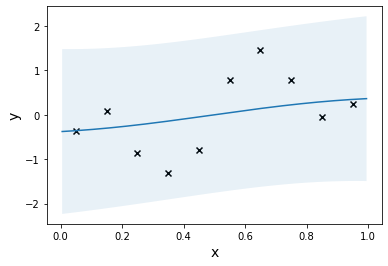

In [8]:
utils.plot_model(model)

### Parameters of the covariance function

Values of parameters of covariance function can be set like:  `kernel.lengthscale = 0.1`.

Let's change the value of `lengthscale` parameter and see how it changes the covariance function.

In [9]:
def plot_kernel(kernel, xlim=None, ax=None):
    if xlim is None:
        xlim = [-3, 5]
    x = torch.linspace(xlim[0], xlim[1], 100)
    with torch.no_grad():
        K = kernel(x, torch.ones((1))).evaluate().reshape(-1, 1)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.plot(x.numpy(), K.cpu().numpy())

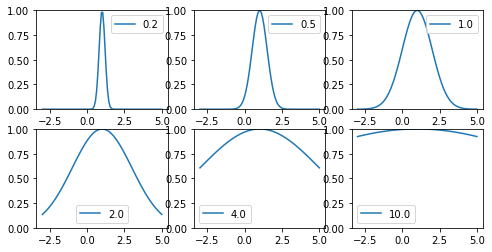

In [10]:
k = kernels.RBFKernel()
theta = np.asarray([0.2, 0.5, 1, 2, 4, 10])
figure, axes = plt.subplots(2, 3, figsize=(8, 4))
for t, ax in zip(theta, axes.ravel()):
    k.lengthscale = t
    plot_kernel(k, ax=ax)
    ax.set_ylim([0, 1])
    ax.legend([t])

### Task
Try to change parameters to obtain more accurate model.

*If you use scale kernel (`kernel = kernels.ScaleKernel(base_kernel)`) then you can access
the parameters of `base_kernel` like this:*
```python
kernel.base_kernel.lengthscale = 1
```

**Question**: based on the input points `X` can we guess the `lengthscale` approximately?

In [ ]:
######## Your code goes here ########

### Your code ends here ###

Check yourself

In [ ]:
model.likelihood.noise = 0.01
utils.plot_model(model)

### Tuning parameters of the covariance function

The parameters are tuned by maximizing likelihood. To do it just use `optimize()` method of the model.

In [11]:
kernel = kernels.ScaleKernel(kernels.RBFKernel())
model = GPRegressor(X, y, kernel)

In [12]:
# Find optimal model hyperparameters
def train(model, X, y, n_epochs=100, lr=0.3, fix_noise_variance=None, verbose=True):
    """
    """
    model.train()

    # Use the adam optimizer
    if fix_noise_variance is not None:
        model.likelihood.noise = fix_noise_variance
        training_parameters = [p for name, p in model.named_parameters()
                               if not name.startswith('likelihood')]
    else:
        training_parameters = model.parameters()
        
    optimizer = torch.optim.Adamax(training_parameters, lr=lr)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    with tqdm.trange(n_epochs, disable=not verbose) as bar:
        for i in bar:
    
            optimizer.zero_grad()
            
            out = model(X)
            loss = -mll(out, y)
            loss.backward()

            optimizer.step()
                        
            # display progress bar
            postfix = dict(Loss=f"{loss.item():.3f}",
                           noise=f"{model.likelihood.noise.item():.3}")
            
            if (hasattr(model.kernel, 'base_kernel') and
                hasattr(model.kernel.base_kernel, 'lengthscale')):
                lengthscale = model.kernel.base_kernel.lengthscale
                if lengthscale is not None:
                    lengthscale = lengthscale.squeeze(0).detach().cpu().numpy()
            else:
                lengthscale = model.kernel.lengthscale

            if lengthscale is not None:
                if len(lengthscale) > 1:
                    lengthscale_repr = [f"{l:.3f}" for l in lengthscale]
                    postfix['lengthscale'] = f"{lengthscale_repr}"
                else:
                    postfix['lengthscale'] = f"{lengthscale[0]:.3f}"
                
            bar.set_postfix(postfix)

100%|██████████| 100/100 [00:00<00:00, 110.70it/s, Loss=0.848, noise=0.0192, lengthscale=0.131]


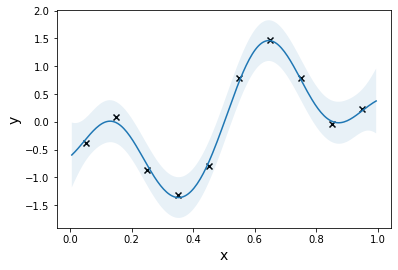

In [13]:
train(model, X, y)
utils.plot_model(model)

### Noise variance

Noise variance acts like a regularization in GP models. Larger values of noise variance lead to more smooth model.  

**Task**: try to change noise variance to some large value, to some small value and plot the results.

Noise variance accessed like this: `model.likelihood.noise = 1`  
To fix it during training you can pass `fix_noise_variance` argument to `train()` method.

In [ ]:
######## Your code here ########


Now, let's generate more noisy data and try to fit model.

In [ ]:
N = 40
X = torch.linspace(0.05, 0.95, N)
y = -torch.cos(np.pi * X) + torch.sin(4 * np.pi * X) + torch.randn(N) * 0.5

kernel = kernels.ScaleKernel(kernels.RBFKernel())
model = GPRegressor(X, y, kernel)

train(model, X, y)
utils.plot_model(model)

Now, let's fix noise variance to some small value and fit the model

In [ ]:
kernel = kernels.ScaleKernel(kernels.RBFKernel())

model = GPRegressor(X, y, kernel)

train(model, X, y, fix_noise_variance=0.1, n_epochs=200)

utils.plot_model(model)

## Approximate multi-dimensional function

In [14]:
def rosenbrock(x):
    x = 0.5 * (4 * x - 2)
    y = np.sum((1 - x[:, :-1])**2 +
                   100 * (x[:, 1:] - x[:, :-1]**2)**2, axis=1)
    return y

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.metrics import mean_squared_error


def plot_2d_func(func, n_rows=1, n_cols=1, title=None):
    grid_size = 100
    x_grid = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size))
    x_grid = np.hstack((x_grid[0].reshape(-1, 1), x_grid[1].reshape(-1, 1)))
    y = func(x_grid)
    fig = plt.figure(figsize=(n_cols * 6, n_rows * 6))
    ax = fig.add_subplot(n_rows, n_cols, 1, projection='3d')
    ax.plot_surface(x_grid[:, 0].reshape(grid_size, grid_size), x_grid[:, 1].reshape(grid_size, grid_size),
                    y.reshape(grid_size, grid_size),
                    cmap=cm.jet, rstride=1, cstride=1)
    if title is not None:
        ax.set_title(title)
    return fig

#### Here how the function looks like in 2D

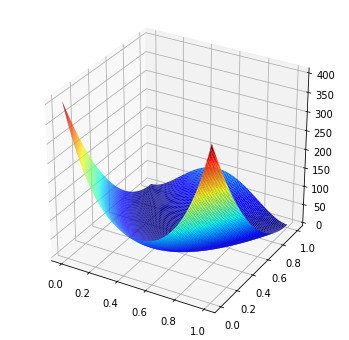

In [16]:
fig = plot_2d_func(rosenbrock)

### Training set
Note that it is 3-dimensional now

In [17]:
dim = 3
X = torch.tensor(np.random.rand(300, dim), dtype=torch.float64)
y = torch.from_numpy(rosenbrock(X.numpy()))

### Task

Try to approximate Rosenbrock function using RBF kernel. MSE (mean squared error) should be $<10^{-2}$.
**Hint**: if results are not good maybe it is due to bad local minimum. You can do one of the following things:
0. Use `double()` for all evaluations
1. Try to use different initial values of hyperparameters.
2. Constrain model parameters to some reasonable bounds. You can do it for example as follows: 

```
constraint = gpytorch.constraints.Interval(0.0, 1.0)
kernel = kernels.RBFKernel(lengthscale_constraint=constraint)
```
3. What about scaling of the data? Does it affect kernel matrix?

In [ ]:
######## Your code here ########


In [ ]:
print(f"Outputscale: {model.kernel.outputscale.item():.3f}\n"
      f"Lengthscale: {model.kernel.base_kernel.lengthscale.detach().cpu().numpy()[0]}\n"
      f"Noise variance: {model.likelihood.noise.item()}")

**Task**: calculate MSE

In [ ]:
x_test = np.random.rand(3000, dim)
y_test = rosenbrock(x_test)
model.eval()

# Turn off some optimization if gpytorch for more accurate computation of the prediction
with gpytorch.settings.fast_computations(False, False, False):
    y_pr = model.predict(torch.from_numpy(x_test)).mean.numpy()

    
### Your code goes here ### 
# Calculate Mean Squared Error using y_pr as a prediction



### Your code ends here ###


print('\nMSE: {}'.format(mse))

# Covariance functions

The most popular covariance function is RBF. However, not all the functions can be modelled using RBF covariance function. For example, approximations of discontinuous functions will suffer from oscillations, approximation of curvy function may suffer from oversmoothing.

In [18]:
def heaviside(x):
    return np.asfarray(x > 0)


def rastrigin(x):
    """
    Parameters
    ----------
    x : ndarray - 2D array in [0, 1]
    
    Returns
    -------
    y : 1D array of values of Rastrigin function
    """
    scale = 8  # 10.24
    x = scale * x - scale / 2
    y = 10 * x.shape[1] + (x**2).sum(axis=1) - 10 * np.cos(2 * np.pi * x).sum(axis=1)
    return y

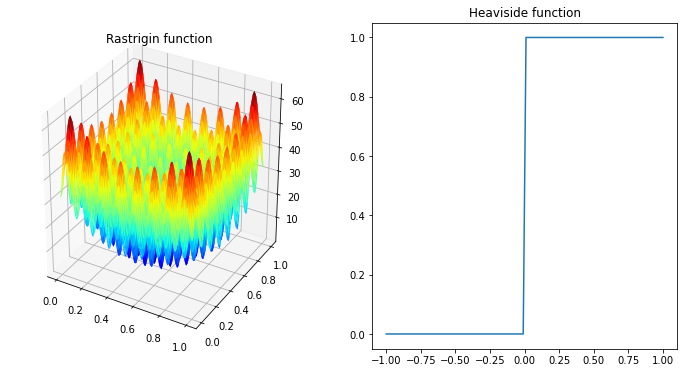

In [19]:
fig = plot_2d_func(rastrigin, 1, 2, title='Rastrigin function')

x = np.linspace(-1, 1, 100)
y = heaviside(x)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x, y)
ax.set_title('Heaviside function')
plt.show()

#### Example of oscillations
As you can see there are oscillations in viscinity of discontinuity because we are trying to approximate
discontinuous function using infinitily smooth function.

100%|██████████| 100/100 [00:00<00:00, 123.93it/s, Loss=-1.559, noise=0.000108, lengthscale=0.089]


(-0.2, 1.2)

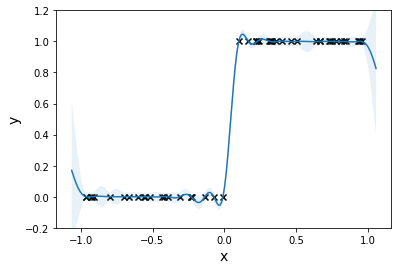

In [20]:
# torch.manual_seed(1150061746)
X = torch.rand(50, 1) * 2 - 1
y = torch.tensor(heaviside(X.numpy())).float().squeeze()

kernel = kernels.ScaleKernel(kernels.RBFKernel())
model = GPRegressor(X, y, kernel)
train(model, X, y)

utils.plot_model(model)
plt.ylim([-0.2, 1.2])

#### Example of oversmoothing
Actually, the GP model only approximates trend of the function.
All the curves are treated as noise.
The knowledge about this (in fact there is some repeated structure) should be incorporated into the model via kernel function.

100%|██████████| 100/100 [00:01<00:00, 55.91it/s, Loss=14.380, noise=4.55, lengthscale=0.279]


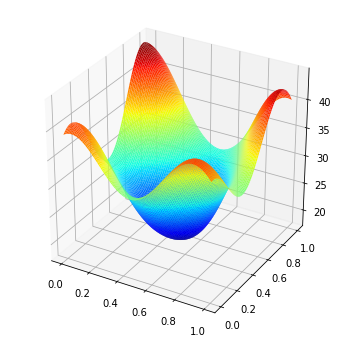

In [21]:
np.random.seed(42)

X = torch.rand(300, 2)
y = torch.tensor(rastrigin(X.numpy()), dtype=torch.float32).squeeze()

kernel = kernels.ScaleKernel(kernels.RBFKernel())
model = GPRegressor(X, y, kernel)
train(model, X, y)

fig = plot_2d_func(lambda x: model.predict(torch.tensor(x).float()).mean.numpy())

### Covariance functions

Popular covariance functions: `Exponential`, `Matern32`, `Matern52`, `RatQuad`, `Linear`, `Periodic`. 

* Exponential:
$$
k(x, x') = \sigma^2 \exp \left (-\frac{r}{l} \right), \quad r = \|x - x'\|
$$

* Matern32
$$
k(x, x') = \sigma^2 \left (1 + \sqrt{3}\frac{r}{l} \right )\exp \left (-\sqrt{3}\frac{r}{l} \right )
$$

* Matern52
$$
k(x, x') = \sigma^2 \left (1 + \sqrt{5}\frac{r}{l} + \frac{5}{3}\frac{r^2}{l^2} \right ) \exp \left (-\sqrt{5}\frac{r}{l} \right )
$$

* RatQuad
$$
k(x, x') = \left ( 1 + \frac{r^2}{2\alpha l^2}\right )^{-\alpha}
$$

* Linear
$$
k(x, x') = \sum_i \sigma_i^2 x_i x_i'
$$

* Polynomial
$$
k(x, x') = \sigma^2 (x^T x' + c)^d
$$

* Periodic
$$
k(x, x') = \sigma^2 \exp\left ( -2 \frac{\sin^2(\pi r)}{l^2}\right )
$$

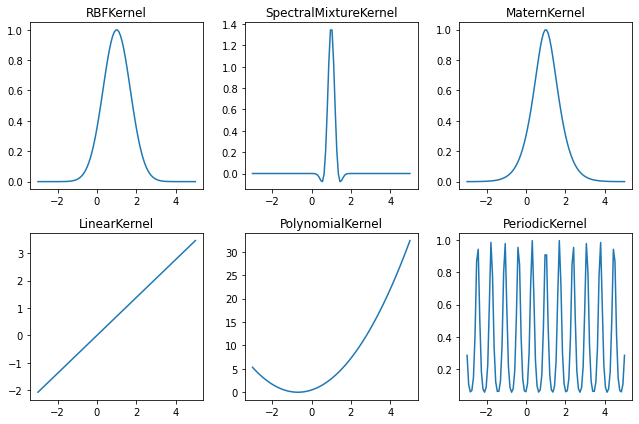

In [22]:
covariance_functions = [kernels.RBFKernel(), kernels.SpectralMixtureKernel(2),
                        kernels.MaternKernel(nu=5/2), kernels.LinearKernel(power=1),
                        kernels.PolynomialKernel(power=2), kernels.PeriodicKernel(),
                       ]
figure, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.ravel()
for i, k in enumerate(covariance_functions):
    plot_kernel(k, ax=axes[i])
    axes[i].set_title(str(k).split('(')[0])
figure.tight_layout()

## Combination of covariance functions

* Sum of covariance function is a valid covariance function:

$$
k(x, x') = k_1(x, x') + k_2(x, x')
$$

* Product of covariance functions is a valid covariance funciton:
$$
k(x, x') = k_1(x, x') k_2(x, x')
$$

### Combinations of covariance functions in GPytorch

In GPytorch to combine covariance functions you can just use operators `+` and `*`.

Let's plot some of the combinations

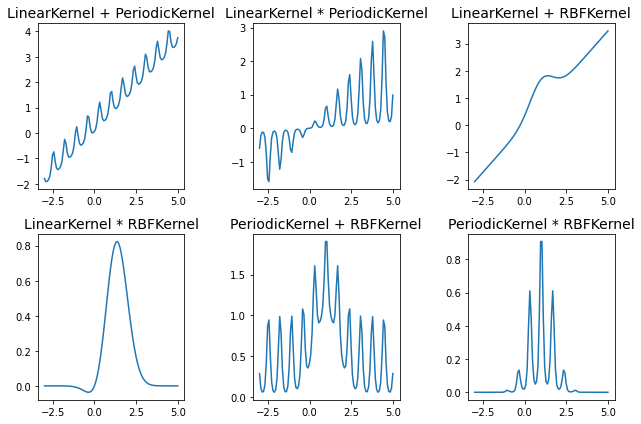

In [23]:
covariance_functions = [kernels.LinearKernel(power=1), kernels.PeriodicKernel(),
                        kernels.RBFKernel()]
operations = {'+': lambda x, y: x + y,
              '*': lambda x, y: x * y}

figure, axes = plt.subplots(len(operations), len(covariance_functions), figsize=(9, 6))

import itertools
axes = axes.ravel()
count = 0
for j, base_kernels in enumerate(itertools.combinations(covariance_functions, 2)):
    for k, (op_name, op) in enumerate(operations.items()):
        kernel = op(base_kernels[0], base_kernels[1])
        plot_kernel(kernel, ax=axes[count])
        kernel_names = [
            str(base_kernels[i]).split('(')[0] for i in [0, 1]
        ]
        axes[count].set_title('{} {} {}'.format(kernel_names[0], op_name, kernel_names[1]),
                              fontsize=14)
        count += 1
figure.tight_layout()

### Additive kernels

One of the popular approach to model the function of interest is
$$
f(x) = \sum_{i=1}^d f_i(x_i) + \sum_{i < j} f_{ij}(x_i, x_j) + \ldots
$$

**Example**: $\quad f(x_1, x_2) = f_1(x_1) + f_2(x_2)$  
To model it using GP use additive kernel $\quad k(x, y) = k_1(x_1, y_1) + k_2(x_2, y_2)$.

More general - add kernels each depending on subset of inputs
$$
k(x, y) = k_1(x, y) + \ldots + k_D(x, y),
$$
where, for example, $k_1(x, x') = k_1(x_1, x_1'), \; k_2(x, x') = k_2((x_1, x_3), (x_1', x_3'))$, etc.

Here is an example of ${\rm RBF}(x_1) + {\rm RBF}(x_2)$

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


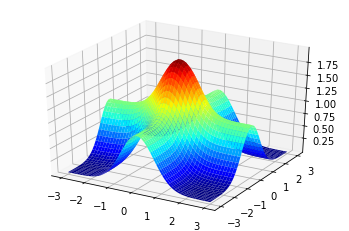

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create kernel
k1 = kernels.RBFKernel(active_dims=[0])
k2 = kernels.RBFKernel(active_dims=[1])

kernel = k1 + k2

# evaluate kernel on grid
x = torch.meshgrid(torch.linspace(-3, 3, 50), torch.linspace(-3, 3, 50))
x = torch.cat([x[0].reshape(-1, 1), x[1].reshape(-1, 1)], dim=1)

with torch.no_grad():
    z = kernel(x, torch.tensor([[0., 0.]])).evaluate()

# Plot kernel
figure = plt.figure()
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(x[:, 0].reshape(50, 50).numpy(),
                x[:, 1].reshape(50, 50).numpy(),
                z.reshape(50, 50).numpy(), cmap=cm.jet)
plt.show()

### Kernels on arbitrary types of objects

Kernels can be defined over all types of data structures: text, images, matrices, graphs, etc. You just need to define similarity between objects.

#### Kernels on categorical data

* Represent your categorical variable as a by a one-of-k encoding: $\quad x = (x_1, \ldots, x_k)$.
* Use RBF kernel with `ARD=True`: $\quad k(x , x') = \sigma^2 \prod_{i = 1}^k\exp{\left ( -\dfrac{(x_i - x_i')^2}{\sigma_i^2} \right )}$. The lengthscale will now encode whether the rest of the function changes.
* Short lengthscales for categorical variables means your model is not sharing any information between data of different categories. 

## 2 Sampling from GP

So, you have defined some complex kernel.
You can plot it to see how it looks and guess what kind of functions it can approximate.
Another way to do it is to actually generate random functions using this kernel.

GP defines distribution over functions, which is defined by its *mean function* $m(x)$ and *covariance function* $k(x, y)$: for any set $\mathbf{x}_1, \ldots, \mathbf{x}_N \in \mathbb{R}^d \rightarrow$ $\left (f(\mathbf{x}_1), \ldots, f(\mathbf{x}_N) \right ) \sim \mathcal{N}(\mathbf{m}, \mathbf{K})$,
where $\mathcal{m} = (m(\mathbf{x}_1, \ldots, \mathbf{x}_N)$, $\mathbf{K} = \|k(\mathbf{x}_i, \mathbf{x}_j)\|_{i,j=1}^N$.

Sampling procedure:

1. Generate set of points $\mathbf{x}_1, \ldots, \mathbf{x}_N$.
2. Calculate mean and covariance matrix $\mathcal{m} = (m(\mathbf{x}_1, \ldots, \mathbf{x}_N)$, $\mathbf{K} = \|k(\mathbf{x}_i, \mathbf{x}_j)\|_{i,j=1}^N$.
3. Generate vector from multivariate normal distribution $\mathcal{N}(\mathbf{m}, \mathbf{K})$.

Below try to change RBF kernel to some other kernel and see the results.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


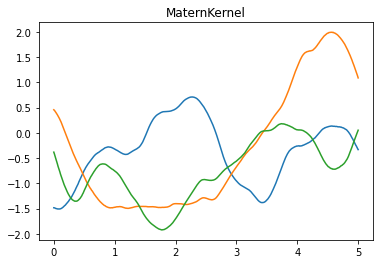

In [25]:
kernel = kernels.MaternKernel(nu=5/2)

X = torch.linspace(0, 5, 500)

mu = np.zeros(500)

with torch.no_grad():
    C = kernel(X).evaluate().numpy()

Z = np.random.multivariate_normal(mu, C, 3)

plt.figure()
for i in range(3):
    plt.plot(X.numpy(), Z[i, :])
    plt.title(str(kernel).split('(')[0])

### Task

Build a GP model that predicts airline passenger counts on international flights.

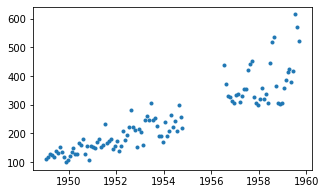

In [26]:
data = np.load('airline.npz')

X = torch.tensor(data['X'])
y = torch.tensor(data['y']).squeeze()

train_indices = list(range(70)) + list(range(90, 129))
test_indices = range(70, 90)
X_train = X[train_indices]
y_train = y[train_indices]

X_test = X[test_indices]
y_test = y[test_indices]

plt.figure(figsize=(5, 3))
plt.plot(X_train.numpy(), y_train.numpy(), '.')

You need to obtain something like this

![](https://raw.githubusercontent.com/yeahrmek/BayesOpt_tutorial/master/GP/airline_result.png)

#### Let's try RBF kernel

In [ ]:
######## Your code here ########


As you can see below it doesn't work ;(

In [ ]:
model = GPRegressor(X_train, y_train, k_rbf).double()
train(model, X_train, y_train, n_epochs=500)

for name, p in model.named_hyperparameters():
    print(f"{name}: {p.item():.3f}")
    
xlim = [1948, 1964]
utils.plot_model(model, xlim=xlim)

We will try to model this data set using 3 additive components: trend, seasonality and noise.  
So, the kernel should be a sum of 3 kernels:  
`kernel = kernel_trend + kernel_seasonality + kernel_noise`

#### Let's first try to model trend

Trend is almost linear with some small nonlinearity, so you can use sum of linear kernel with some other which gives this small nonlinearity.

In [ ]:
######## Your code here ########


In [ ]:
model = GPRegressor(X_train, y_train, k_trend).double()
train(model, X_train, y_train, n_epochs=1000)

for name, p in model.named_hyperparameters():
    print(f"{name}: {p.item():.3f}")
    
utils.plot_model(model, xlim=xlim)

#### Let's model periodicity
Just periodic kernel will not work (why?).
Try to use product of periodic kernel with some other kernel (or maybe 2 other kernels).
Note that the amplitude increases with x.

In [ ]:
######## Your code here ########


In [ ]:
kernel = kernels.AdditiveKernel(k_trend, k_seasonal)

model = GPRegressor(X_train, y_train, kernel).double()

train(model, X_train, y_train, n_epochs=1000)

for name, p in model.named_hyperparameters():
    print(f"{name}: {p.item():.3f}")
    
utils.plot_model(model, xlim=xlim)

#### Let's add noise model
The dataset is heteroscedastic, i.e. noise variance depends on x: it increases linearly with x.  
To model homoscedastic white noise we implement `WhiteNoiseKernel`, but it assumes that noise variance is the same at every x.
By what kernel it should be multiplied?

In [29]:
from gpytorch.lazy import DiagLazyTensor, ZeroLazyTensor

class WhiteNoiseKernel(kernels.Kernel):
    def __init__(self, noise=1):
        super().__init__()
        self.noise = noise
    
    def forward(self, x1, x2, **params):
        if self.training and torch.equal(x1, x2):
            return DiagLazyTensor(torch.ones(x1.shape[0]).to(x1) * self.noise)
        elif x1.size(-2) == x2.size(-2) and torch.equal(x1, x2):
            return DiagLazyTensor(torch.ones(x1.shape[0]).to(x1) * self.noise)
        else:
            return torch.zeros(x1.shape[0], x2.shape[0]).to(x1)

In [ ]:
######## Your code here ########


In [ ]:
kernel = kernels.AdditiveKernel(k_trend, k_seasonal, k_noise)

model = GPRegressor(X_train, y_train, kernel).double()

train(model, X_train, y_train, n_epochs=1000)

for name, p in model.named_hyperparameters():
    print(f"{name}: {p.item():.3f}")

utils.plot_model(model, xlim=xlim)